## Mount to gdrive to read data, adjacency matrix, p_link and labels. 

In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


# Install pandas to read csv files from gdrive. Install torch and numpy which are packages that are needed durind coding.

In [ ]:
!pip install pandas
import pandas as pd
import torch
import numpy as np

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Load data which are processed in preprocessing_data_7classes.ipynb file.

In [ ]:
path = F"/gdrive/MyDrive/7classes.sim/data_7classes.pt"
Data = torch.load(path)
Data

{'x': tensor([[-0.6680,  0.3545,  0.1382,  ...,  2.1196,  0.2813,  1.3384],
         [ 0.0282,  1.6481,  1.9474,  ...,  0.8241,  0.9470,  1.9798],
         [-0.4644,  0.5799,  0.0618,  ..., -0.5351, -0.2698,  0.9294],
         ...,
         [-0.2195, -0.8809,  0.0466,  ..., -0.5610,  2.1045, -0.2778],
         [-0.7321,  0.0596,  1.4736,  ...,  0.7870,  0.7216, -1.5205],
         [ 1.0196,  0.5744,  0.3943,  ...,  1.7039, -1.3692,  0.6619]]),
 'edge_index': tensor([[ 0,  0,  0,  0,  0,  0,  1,  1,  1,  2,  2,  2,  2,  2,  2,  3,  3,  4,
           4,  4,  4,  4,  4,  4,  4,  4,  5,  5,  6,  6,  6,  6,  6,  6,  6,  6,
           6,  7,  8,  8,  8,  8,  8,  8,  8,  9,  9,  9,  9,  9,  9,  9,  9,  9,
           9, 10, 10, 11, 11, 11, 12, 12, 13, 13, 14, 14, 14, 14, 15, 15, 16, 16,
          17, 17, 17, 18, 18, 19, 19, 19, 20, 20, 20, 20, 20, 20, 20, 21, 21, 21,
          21, 21, 22, 22, 22, 22, 23, 24, 24, 24, 24, 25, 25, 26, 26, 26, 26, 27,
          27, 27, 28, 28, 29, 29, 29, 30, 30, 3

In [ ]:
path = F"/gdrive/MyDrive/7classes.sim/p_links_7classes.pt"
p_link = torch.load(path)
print(p_link.size())
print(p_link.dtype)
print(p_link.type())

torch.Size([70, 70])
torch.float32
torch.FloatTensor


# Install torch_geometic.

In [ ]:
import os
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

1.13.0+cu116


# Create BGAT and GAT layers. 

In [ ]:
from torch_geometric.nn import MessagePassing
import torch_geometric.nn
import torch.nn.functional as F
from torch_geometric.utils import add_self_loops
from torch_geometric.nn import GATConv

In [ ]:
class BGATConv(MessagePassing):
    def __init__(
        self,
        in_channels,
        out_channels,
        **kwargs,
    ):
        kwargs.setdefault('aggr', 'add')
        super().__init__(node_dim = 0, **kwargs)
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.lin = torch.nn.Linear(in_channels, out_channels)

    def forward(self, x, edge_index):
        edge_index, _ = add_self_loops(Data["edge_index"], num_nodes = Data["x"].size(0))
        x = self.lin(x)
        atten = p_link
        return self.propagate(edge_index, x=x, atten = atten)

    def message(self, x_j, atten, edge_index_i, edge_index_j):
        return atten[edge_index_i, edge_index_j].reshape(-1,1) * x_j

    def __repr__(self):
        return '{}({}, {})'.format(self.__class__.__name__, self.in_channels, self.out_channels)

In [ ]:
class Myconv_BGAT(torch.nn.Module):
    def __init__(self):
        super().__init__()
        torch.manual_seed(2)
        self.conv1 = BGATConv(in_channels = 500, out_channels = 15)
        self.conv2 =  BGATConv(15, 10)
        self.conv3 =  BGATConv(10, 7)
        
    def forward(self, x, edge_index):
        h = self.conv1(x, edge_index)
        h = F.torch.tanh(h)
        h = self.conv2(h, edge_index)
        h = F.torch.tanh(h)
        h = self.conv3(h, edge_index)# Final GNN embedding space.
        h = F.log_softmax(h)
        return h
        
model_BGAT = Myconv_BGAT()
print(model_BGAT)
print(model_BGAT.forward(Data["x"], Data["edge_index"]))

Myconv_BGAT(
  (conv1): BGATConv(500, 15)
  (conv2): BGATConv(15, 10)
  (conv3): BGATConv(10, 7)
)
tensor([[ -1.6038,  -3.5480,  -0.7512,  -1.4632,  -4.1339,  -3.0155,  -6.3295],
        [ -1.8167,  -2.2806,  -2.1076,  -0.7447,  -3.9225,  -2.1941,  -4.8831],
        [ -1.9168,  -2.9504,  -2.5775,  -0.3901,  -5.1676,  -3.2022,  -6.6732],
        [ -1.7701,  -1.8791,  -1.9542,  -0.9096,  -3.5461,  -2.4490,  -4.0514],
        [ -3.2950,  -2.7694,  -4.2013,  -0.1424,  -8.1786,  -4.0349, -10.3955],
        [ -1.8265,  -2.6651,  -1.5127,  -1.7854,  -2.1845,  -1.6247,  -2.6327],
        [ -1.9964,  -6.3456,  -8.2527,  -0.1534, -10.2619,  -5.4350, -17.6342],
        [ -1.3819,  -2.4975,  -1.5486,  -1.5245,  -2.3928,  -2.1056,  -3.7649],
        [ -1.8369,  -5.1594,  -7.4488,  -0.1958,  -8.7107,  -4.4240, -14.7349],
        [ -1.3772,  -7.2671,  -8.1324,  -0.2954,  -9.9204,  -5.9984, -18.6348],
        [ -1.7579,  -1.9779,  -1.7986,  -1.2895,  -2.9389,  -1.7297,  -4.0152],
        [ -1.3286,  -

<ipython-input-8-cedf2bd29c67>:15: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  h = F.log_softmax(h)


In [ ]:
class Myconv_GAT(torch.nn.Module):
    def __init__(self):
        super().__init__()
        torch.manual_seed(2)
        self.conv1 = GATConv(in_channels = 500, out_channels = 50)
        self.conv2 =  GATConv(50, 10)
        self.conv3 =  GATConv(10, 7)
        

    def forward(self, x, edge_index):
        f = self.conv1(x, edge_index)
        f = F.torch.tanh(f)
        f = self.conv2(f, edge_index)
        f = F.torch.tanh(f)
        f = self.conv3(f, edge_index)# Final GNN embedding space.
        f = F.log_softmax(f)
        return f
        

model_GAT = Myconv_GAT()
print(model_GAT)
print(model_GAT.forward(Data["x"], Data["edge_index"]))

Myconv_GAT(
  (conv1): GATConv(500, 50, heads=1)
  (conv2): GATConv(50, 10, heads=1)
  (conv3): GATConv(10, 7, heads=1)
)
tensor([[-2.4665, -2.1269, -2.5751, -1.0695, -1.9733, -1.8291, -2.5636],
        [-1.8347, -2.6898, -2.3343, -2.1443, -1.2235, -2.2313, -1.8525],
        [-1.7384, -2.0836, -2.0600, -1.8335, -1.9923, -1.9708, -1.9902],
        [-1.6594, -2.1520, -1.9603, -1.3046, -2.4086, -2.3315, -2.3610],
        [-1.9883, -2.0943, -2.3361, -1.6303, -1.9120, -1.7473, -2.0770],
        [-1.6118, -2.5256, -2.4606, -1.6407, -1.6896, -1.9180, -2.2097],
        [-1.8169, -1.7161, -2.2494, -2.0461, -2.2622, -1.8042, -1.8689],
        [-2.1201, -2.3137, -1.9353, -1.6325, -1.7257, -1.7829, -2.3532],
        [-1.8635, -1.6950, -2.2745, -2.0713, -2.2583, -1.7564, -1.8630],
        [-2.0157, -1.7854, -2.4848, -1.8401, -2.0994, -1.6568, -1.9406],
        [-2.0922, -2.0198, -2.5697, -1.3342, -2.1416, -1.8899, -1.9993],
        [-1.9327, -2.5701, -2.1212, -1.4091, -1.7320, -1.9227, -2.3935],
  

<ipython-input-9-9840ba522053>:16: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  f = F.log_softmax(f)


# Train BGAT and GAT models. 

In [ ]:
model = Myconv_BGAT()
criterion = torch.nn.CrossEntropyLoss()  # Define loss criterion.
optimizer = torch.optim.Adam(model.parameters(),  lr = 0.005)  # Define optimizer, an object for updating parameters
#loss = loss + weight decay parameter * L2 norm of the weights, 1) To prevent overfitting 2) To keep the weights small and avoid exploding gradient

def train_BGAT(Data):
    model.train()
    optimizer.zero_grad()  # Clear gradients.
    out = model(Data["x"], Data["edge_index"])
    train_loss_BGAT = criterion(out[Data["train_mask"]], Data["y"][Data["train_mask"]])  # Compute the loss solely based on the training nodes.
    train_loss_BGAT.backward()  # Derive gradients.
    optimizer.step()  # Update parameters based on gradients.
    return train_loss_BGAT

train_loss_BGAT_ = []
for epoch in range(1, 101):
  epoch_train_lossBGAT = []
  train_loss_BGAT = train_BGAT(Data)
  epoch_train_lossBGAT.append(train_loss_BGAT.item())
  train_loss_BGAT_.append(sum(epoch_train_lossBGAT)/len(epoch_train_lossBGAT))
  print(f'Train_BGAT:  {train_loss_BGAT:.3f}')    

Train_BGAT:  2.976
Train_BGAT:  1.667
Train_BGAT:  1.232


<ipython-input-8-cedf2bd29c67>:15: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  h = F.log_softmax(h)


Train_BGAT:  0.977
Train_BGAT:  0.773
Train_BGAT:  0.676
Train_BGAT:  0.624
Train_BGAT:  0.580
Train_BGAT:  0.542
Train_BGAT:  0.508
Train_BGAT:  0.478
Train_BGAT:  0.451
Train_BGAT:  0.426
Train_BGAT:  0.405
Train_BGAT:  0.385
Train_BGAT:  0.368
Train_BGAT:  0.352
Train_BGAT:  0.337
Train_BGAT:  0.323
Train_BGAT:  0.310
Train_BGAT:  0.298
Train_BGAT:  0.287
Train_BGAT:  0.277
Train_BGAT:  0.267
Train_BGAT:  0.258
Train_BGAT:  0.250
Train_BGAT:  0.241
Train_BGAT:  0.234
Train_BGAT:  0.227
Train_BGAT:  0.221
Train_BGAT:  0.215
Train_BGAT:  0.209
Train_BGAT:  0.204
Train_BGAT:  0.199
Train_BGAT:  0.194
Train_BGAT:  0.189
Train_BGAT:  0.185
Train_BGAT:  0.181
Train_BGAT:  0.177
Train_BGAT:  0.172
Train_BGAT:  0.168
Train_BGAT:  0.165
Train_BGAT:  0.161
Train_BGAT:  0.158
Train_BGAT:  0.155
Train_BGAT:  0.151
Train_BGAT:  0.148
Train_BGAT:  0.145
Train_BGAT:  0.143
Train_BGAT:  0.140
Train_BGAT:  0.137
Train_BGAT:  0.135
Train_BGAT:  0.132
Train_BGAT:  0.130
Train_BGAT:  0.127
Train_BGAT: 

In [ ]:
model = Myconv_GAT()
criterion = torch.nn.CrossEntropyLoss()  # Define loss criterion.
optimizer = torch.optim.Adam(model.parameters(),  lr = 0.0005)  # Define optimizer, an object for updating parameters
#loss = loss + weight decay parameter * L2 norm of the weights, 1) To prevent overfitting 2) To keep the weights small and avoid exploding gradient

def train_GAT(Data):
    model.train()
    optimizer.zero_grad()  # Clear gradients.
    out = model(Data["x"], Data["edge_index"])
    train_loss_GAT = criterion(out[Data["train_mask"]], Data["y"][Data["train_mask"]])  # Compute the loss solely based on the training nodes.
    train_loss_GAT.backward()  # Derive gradients.
    optimizer.step()  # Update parameters based on gradients.
    return train_loss_GAT

train_loss_GAT_ = []
for epoch in range(1, 101):
  epoch_train_lossGAT = []
  train_loss_GAT = train_GAT(Data)
  epoch_train_lossGAT.append(train_loss_GAT.item())
  train_loss_GAT_.append(sum(epoch_train_lossGAT)/len(epoch_train_lossGAT))
  print(f'Train_GAT:  {train_loss_GAT:.3f}')    

Train_GAT:  2.105
Train_GAT:  1.922
Train_GAT:  1.786
Train_GAT:  1.701
Train_GAT:  1.632
Train_GAT:  1.566
Train_GAT:  1.501
Train_GAT:  1.447
Train_GAT:  1.397
Train_GAT:  1.350
Train_GAT:  1.307
Train_GAT:  1.264
Train_GAT:  1.223
Train_GAT:  1.185


<ipython-input-9-9840ba522053>:16: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  f = F.log_softmax(f)


Train_GAT:  1.151
Train_GAT:  1.122
Train_GAT:  1.097
Train_GAT:  1.074
Train_GAT:  1.052
Train_GAT:  1.031
Train_GAT:  1.010
Train_GAT:  0.989
Train_GAT:  0.969
Train_GAT:  0.949
Train_GAT:  0.930
Train_GAT:  0.912
Train_GAT:  0.895
Train_GAT:  0.880
Train_GAT:  0.867
Train_GAT:  0.855
Train_GAT:  0.843
Train_GAT:  0.831
Train_GAT:  0.819
Train_GAT:  0.808
Train_GAT:  0.797
Train_GAT:  0.787
Train_GAT:  0.777
Train_GAT:  0.769
Train_GAT:  0.760
Train_GAT:  0.752
Train_GAT:  0.744
Train_GAT:  0.737
Train_GAT:  0.730
Train_GAT:  0.724
Train_GAT:  0.718
Train_GAT:  0.712
Train_GAT:  0.706
Train_GAT:  0.700
Train_GAT:  0.695
Train_GAT:  0.690
Train_GAT:  0.685
Train_GAT:  0.680
Train_GAT:  0.675
Train_GAT:  0.670
Train_GAT:  0.665
Train_GAT:  0.660
Train_GAT:  0.656
Train_GAT:  0.651
Train_GAT:  0.647
Train_GAT:  0.643
Train_GAT:  0.639
Train_GAT:  0.635
Train_GAT:  0.631
Train_GAT:  0.627
Train_GAT:  0.623
Train_GAT:  0.619
Train_GAT:  0.616
Train_GAT:  0.612
Train_GAT:  0.608
Train_GAT:

# Visualize train_loss for both models. 

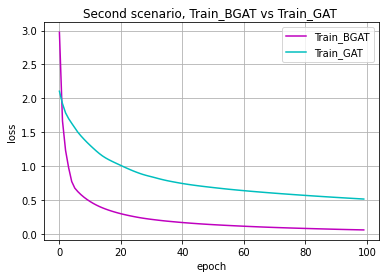

In [ ]:
import matplotlib.pyplot as plt
plt.plot(train_loss_BGAT_, "m")
plt.plot(train_loss_GAT_, "c")
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Train_BGAT','Train_GAT'])
plt.title('Second scenario, Train_BGAT vs Train_GAT ')
plt.grid()
plt.show()